In [46]:
import numpy as np
import pandas as pd
import json
import subprocess
import warnings
import cv2
import torch

from tqdm import tqdm
from scipy.signal import find_peaks
from datetime import datetime

from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from collections import Counter

warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Data_path = 'D:/datasets/nilm/plaid/PLAID2018/'
csv_path = Data_path + 'submetered/'
csv_files = os.listdir(csv_path)

In [3]:
# functions to read data and meta data
def read_data_given_id(path,ids, progress=True,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    start = datetime.now()
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress and np.mod(i,np.ceil(n/10))==0:
                print('%d/%d (%2.0f%s) have been read...\t time consumed: %ds'\
                      %(i,n,i/n*100,'%',(datetime.now()-start).seconds))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',delimiter=',',\
                                         names='current,voltage',dtype=(float,float))
            else:

                p = path + str(ist_id) + ".csv"
                with open(p, 'rb') as f:
                    lines = f.readlines()
                    data[ist_id] = np.genfromtxt(lines[-last_offset:], delimiter=',',
                                                 names='current,voltage', dtype=(float, float))
                    f.close()


        print('%d/%d (%2.0f%s) have been read(Done!) \t time consumed: %ds'\
            %(n,n,100,'%',(datetime.now()-start).seconds))
        return data


def clean_meta(ist):
    '''remove '' elements in Meta Data ''' 
    clean_ist = ist.copy()
    for k,v in ist.items():
#         if 
        if len(v) == 0:
            del clean_ist[k]
    return clean_ist


def parse_meta(meta):
    '''parse meta data for easy access'''
    M = {}
    for app in meta:
        M[int(app)] = clean_meta(meta[app])
    return M

In [4]:
import json

with open(Data_path + 'metadata_submetered.json') as data_file:    
    meta = json.load(data_file)

In [5]:
meta['99']

{'appliance': {'brand': '',
  'current': '',
  'load': 'R',
  'manufacture_year': '',
  'model_number': '',
  'notes': '',
  'status': 'off-on',
  'type': 'Hairdryer',
  'voltage': '',
  'wattage': ''},
 'header': {'collection_time': 'July, 2013',
  'notes': 'some instances are not well calibrated, meta data are not complete',
  'sampling_frequency': '30000Hz'},
 'instances': {'length': '1.67s'},
 'location': 'house6'}

In [6]:
Meta = parse_meta(meta)

In [7]:
# applinace types of all instances
Types = [x['appliance']['type'] for x in Meta.values()]
# unique appliance types
Unq_type = list(set(Types)) 
Unq_type.sort()
print(Unq_type)

# houses
Houses = [x['location'] for x in Meta.values()]
# appliances
Apps = [x['location']+'-'+x['appliance']['type'] for x in Meta.values()]

print('number of total instances: %d' % len(Types))
print('number of unique households: %d' % len(set(Houses)))
print('number of unique appliances: %d' % len(set(Apps)))
print('number of unique appliance types: %d' % len(Unq_type))

['Air Conditioner', 'Blender', 'Coffee maker', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Hair Iron', 'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Soldering Iron', 'Vacuum', 'Washing Machine', 'Water kettle']
number of total instances: 1876
number of unique households: 56
number of unique appliances: 279
number of unique appliance types: 16


In [8]:
print('%25s\t%8s\t%8s' % ('Appliance Type', '# Appliances', '# Instances'))
print('-'*70)
for t in Unq_type:
    app_ids = [i for i in Apps if t in i]
    t_ids = [i for i,j in enumerate(Types) if j == t]
    print('%25s\t%10d\t%10d' % (t,len(set(app_ids)),len(t_ids)))
print('-'*70)
print('%25s\t%10d\t%10d' % ('Total',len(set(Apps)),len(Types)))

           Appliance Type	# Appliances	# Instances
----------------------------------------------------------------------
          Air Conditioner	        18	       204
                  Blender	         1	         2
             Coffee maker	         1	        10
 Compact Fluorescent Lamp	        33	       230
                      Fan	        28	       220
                   Fridge	        25	       108
                Hair Iron	         1	        10
                Hairdryer	        34	       246
                   Heater	        10	        85
  Incandescent Light Bulb	        28	       157
                   Laptop	        37	       216
                Microwave	        31	       200
           Soldering Iron	         1	        20
                   Vacuum	        14	        83
          Washing Machine	        16	        75
             Water kettle	         1	        10
----------------------------------------------------------------------
                    Total	       279	  

In [9]:
# read data
# estimated time cost:  ~ 1 mins
IDs_for_read_data = list(Meta.keys())

fs = 30e3
f0 = 60
Ts = fs // f0
N = 10

npts = int(N * Ts)
Data = read_data_given_id(csv_path, IDs_for_read_data, progress=True, last_offset=npts)

188/1876 (10%) have been read...	 time consumed: 2s
376/1876 (20%) have been read...	 time consumed: 4s
564/1876 (30%) have been read...	 time consumed: 6s
752/1876 (40%) have been read...	 time consumed: 8s
940/1876 (50%) have been read...	 time consumed: 10s
1128/1876 (60%) have been read...	 time consumed: 12s
1316/1876 (70%) have been read...	 time consumed: 15s
1504/1876 (80%) have been read...	 time consumed: 17s
1692/1876 (90%) have been read...	 time consumed: 19s
1876/1876 (100%) have been read(Done!) 	 time consumed: 21s


In [10]:
def zero_crossings(voltage):
    """ find the indexes of all points of zero crossings
    """
    return np.where(np.diff(np.sign(voltage)))[0]

def get_zero_crossing(voltage, NN=1000):
    """ get zero crossing

    """
    zero_crossing = zero_crossings(voltage)

    if len(zero_crossing)>0:
        if voltage[zero_crossing[0]+10] > 0:        
            zero_crossing = zero_crossing[0:]       
        else:                                       
            i = 1
            while True:
                if voltage[zero_crossing[i]+10] > 0:
                    zero_crossing = zero_crossing[i:]
                    break
                i = i + 1

    else:
        zero_crossing = None

    return zero_crossing

def align_IV_zero_crossing(i, v, TS):

    ks = []
    cs = []
    current, voltage = np.copy(i), np.copy(v)

    zc = get_zero_crossing(voltage, TS)
    ks = []
    crs = []
    k = 0

    addition = 0
    n_c = 10

    if zc[k] - zc[(k+n_c)] != (TS * 5):
        addition = (TS * 5) - (zc[(k+n_c)] - zc[k])

    voltage = voltage[zc[k]:zc[(k+n_c)] + addition]
    current = current[zc[k]:zc[(k+n_c)] + addition]

    return current, voltage

In [16]:
def get_features(data, M=5, fs=30000, f0=60):

    npts = 10000
    NS = int(fs // f0)         # 30000 // 60 = 500
    NP = int(npts / NS)        # number of periods for npts            # 10000 / 500 = 20

    n = len(data)

    rep_I = []
    rep_V = []
    files_id=0

    with tqdm(total=n) as pbar:
        for i in range(n):
            ind = list(data)[i]                                         

            tempI = data[ind]['current']
            tempV = data[ind]['voltage']

            tempI, tempV = align_IV_zero_crossing(tempI, tempV, NS)

            rep_I.append(tempI)
            rep_V.append(tempV)

            pbar.set_description('processed: %d' % (1 + files_id))
            pbar.update(1)
            files_id+=1
        pbar.close()

    rep_I = np.array(rep_I)
    rep_V = np.array(rep_V)
    return rep_I, rep_V

In [22]:
current, voltage = get_features(Data)

processed: 1876: 100%|█████████████████████████████████████████████████████████████| 1876/1876 [00:01<00:00, 1030.26it/s]


In [23]:
def fryze_power_decomposition(i, v):

    p = i*v
    vrs = v**2
    p_mean = np.mean(p, axis=-1)[:, :, None]
    vrs_mean = np.mean(vrs, axis=-1)[:, :, None]
    i_active = p_mean*v/vrs_mean
    i_non_active = i - i_active
    return i_active, i_non_active

In [25]:
current = current.reshape(current.shape[0], 1, current.shape[1])
voltage = voltage.reshape(voltage.shape[0], 1, voltage.shape[1])

_, i_non_active = fryze_power_decomposition(current, voltage)
print(i_non_active.shape, voltage.shape)

(1876, 1, 2500) (1876, 1, 2500)


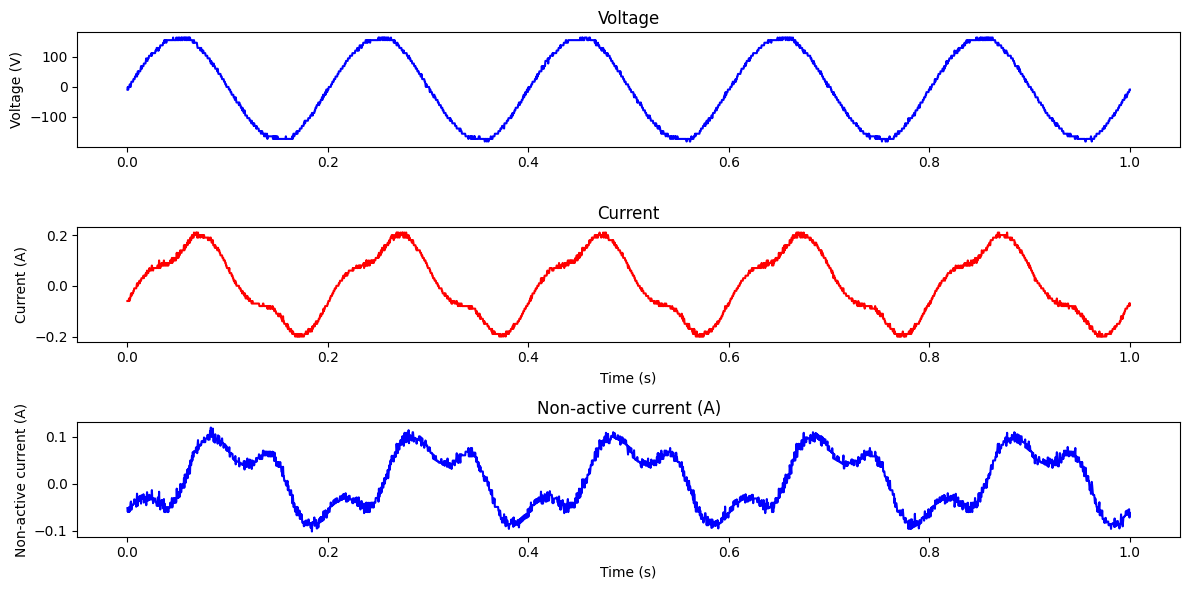

In [26]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

t = np.linspace(0, 1, 2500)

idx = 88
fig, axs = plt.subplots(3, 1, figsize=(12, 6))

axs[0].plot(t, voltage[idx,0], 'b')
axs[0].set_title('Voltage')
axs[0].set_ylabel('Voltage (V)')

axs[1].plot(t, current[idx,0], 'r')
axs[1].set_title('Current')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Current (A)')

axs[2].plot(t, i_non_active[idx][0], 'b')
axs[2].set_title('Non-active current (A)')
axs[2].set_ylabel('Non-active current (A)')
axs[2].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

In [43]:
def center(X,w):
    minX = np.amin(X)
    maxX = np.amax(X)
    dist = max(abs(minX),maxX)
    X[X<-dist] = -dist
    X[X>dist] = dist
    d = (maxX-minX)/(w-1)
    return (X,d)


def get_img_from_VI(V, I, width,hard_threshold=False,para=.5):
    '''Get images from VI, hard_threshold, set para as threshold to cut off,5-10
    soft_threshold, set para to .1-.5 to shrink the intensity'''
    # center the current and voltage, get the size resolution of mesh given width
    d = V.shape[0]
    # doing interploation if number of points is less than width*2
    if d<2* width:
        newI = np.hstack([V, V[0]])
        newV = np.hstack([I, I[0]])
        oldt = np.linspace(0,d,d+1)
        newt = np.linspace(0,d,2*width)
        I = np.interp(newt,oldt,newI)
        V = np.interp(newt,oldt,newV)

    (I,d_c)  = center(I,width)
    (V,d_v)  = center(V,width)

    #  find the index where the VI goes through in current-voltage axis
    ind_c = np.ceil((I-np.amin(I))/d_c)
    ind_v = np.ceil((V-np.amin(V))/d_v)
    ind_c[ind_c==width] = width-1
    ind_v[ind_v==width] = width-1

    Img = np.zeros((width, width))

    for i in range(len(I)):
        Img[int(ind_c[i]), int(width-ind_v[i]-1)] += 1

    if hard_threshold:
        Img[Img<para] = 0
        Img[Img!=0] = 1
        return Img
    else:
        return (Img/np.max(Img))**para

# Combined Hue, Saturation, Value in VI trajectory

# Saturation

def get_HSV_VI(V, I, width, pf, H, M):
    # center the current and voltage, get the size resolution of mesh given width
    d = V.shape[0]
    # doing interploation if number of points is less than width*2
    if d<2* width:
        newI = np.hstack([V, V[0]])
        newV = np.hstack([I, I[0]])
        oldt = np.linspace(0,d,d+1)
        newt = np.linspace(0,d,2*width)
        I = np.interp(newt,oldt,newI)
        V = np.interp(newt,oldt,newV)

    (I,d_c) = center(I,width)
    (V,d_v) = center(V,width)

    #  find the index where the VI goes through in current-voltage axis
    ind_c = np.ceil((I-np.amin(I))/d_c)
    ind_v = np.ceil((V-np.amin(V))/d_v)
    ind_c[ind_c==width] = width-1
    ind_v[ind_v==width] = width-1

    Img = np.zeros((width, width))

    hue = np.zeros((width, width))
    sat = np.zeros((width, width))
    val = np.zeros((width, width))

    for i in range(len(I)):
        Img[int(ind_c[i]), int(width-ind_v[i]-1)] += 1

    # Hue
    for i in range(len(I)-1):
        hue[int(ind_c[i]), int(width-ind_v[i]-1)] += H[i]

    hue = np.where(Img != 0, hue / Img, 0)

    # Saturation
    sat[Img<1] = 0
    sat[Img!=0] = pf

    # Value
    for m in range(M):
            c = I[m*500:(m+1)*500]
            v = V[m*500:(m+1)*500]
            val += get_img_from_VI(v, c, width, True, 0.5)

    val /= 5

    return np.stack([hue, sat, val], axis=0)

def HSV_VI_mapping(current, current_nonactive, voltage, width=32, M=5):

    n = len(voltage)
    Imgs = np.empty((n, 3, width, width), dtype=np.float64)

    with tqdm(n) as pbar:
        for i in range(n):

            ### Hue
            J = len(voltage[i,0])
            v_max = np.max(np.abs(voltage[i,0]))
            i_max = np.max(np.abs(current_nonactive[i,0]))
            H = np.zeros(J)
            for j in range(J-1):
                H[j] = np.arctan2((voltage[i,0,j+1] - voltage[i,0,j])/v_max, (current_nonactive[i,0,j+1] - current_nonactive[i,0,j])/i_max)
                H[j] = np.degrees(H[j])
                if  H[j] < 0:
                    H[j] += 360

            ### Saturation
            # active power
            P = np.mean(voltage[i] * current[i])
            Vrms = np.sqrt(np.mean(voltage[i]**2))
            Irms = np.sqrt(np.mean(current[i]**2))
            S = Vrms * Irms
            pf = P / S

            ### Value
            Imgs[i,:,:,:] = get_HSV_VI(voltage[i,0], current_nonactive[i,0], width, pf, H, M)

            pbar.set_description('processed: %d' % (1 + i))
            pbar.update(1)

        pbar.close()
    # vi = np.reshape(Imgs,(n, 1, width, width))       # {ndarray: (n, W, W)} -> {ndarray: (n, 3, W, W)}
    Imgs = torch.tensor(Imgs).float()                   # {ndarray} -> {Tensor}
    return Imgs


In [47]:
HSV_VI = HSV_VI_mapping(current, i_non_active, voltage, width=32)


processed: 1876: : 1876it [00:17, 107.47it/s]


In [49]:
HSV_VI.shape

torch.Size([1876, 3, 32, 32])

In [50]:
# Transpose the tensor to shape (32, 32, 3)
HSV_VI = HSV_VI.permute(0, 2, 3, 1)

In [51]:
HSV_VI.shape

torch.Size([1876, 32, 32, 3])

In [40]:
HSV_VI[0].shape

(32, 32, 3)

In [ ]:
# # Convert the transposed tensor to a NumPy array
HSV_VI = HSV_VI.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


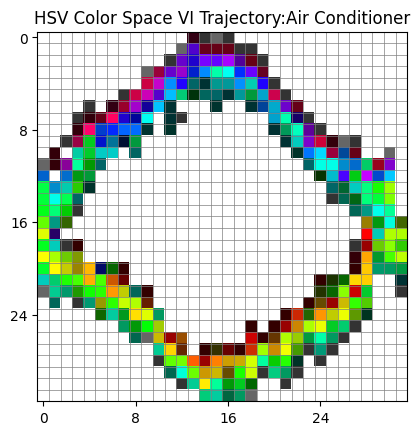

In [61]:
# # Convert the transposed tensor to a NumPy array
index = 354

# Conver to RGB
rgb_image = cv2.cvtColor(HSV_VI[index], cv2.COLOR_HSV2RGB)
rgb_image[(rgb_image == [0, 0, 0]).all(axis=2)] = [255, 255, 255]
plt.imshow(rgb_image)
plt.title(f'HSV Color Space VI Trajectory:{Types[index]}')
# Draw 31 horizontal and vertical grid lines
for i in range(1, 32):
    plt.axhline(i - 0.5, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(i - 0.5, color='gray', linestyle='-', linewidth=0.5)

# Set the ticks to the positions of the grid lines
plt.xticks([0, 8, 16, 24, 32], [0, 8, 16, 24, 32])
plt.yticks([0, 8, 16, 24, 32], [0, 8, 16, 24, 32])
# Set limits to ensure the ticks appear correctly
plt.xlim(-0.5, 31.5)
plt.ylim(31.5, -0.5)

plt.show()